#Visialization

# Phân tích và Trực quan hóa các Hàm Tổn thất cho Nhận dạng

Notebook này trình bày việc trực quan hóa ranh giới quyết định (decision boundaries) và không gian nhúng (embedding space) học được bởi các hàm tổn thất khác nhau trong bài toán phân loại. Mục tiêu là so sánh cách mà mỗi hàm tổn thất ảnh hưởng đến việc phân tách các lớp, đặc biệt là việc tạo ra "lề" (margin) giữa các lớp.

Các hàm tổn thất được phân tích bao gồm:
1.  **Softmax Loss:** Hàm tổn thất cơ bản không có lề rõ ràng.
2.  **SphereFace Loss:** Giới thiệu lề góc (angular margin).
3.  **CosFace Loss:** Giới thiệu lề cosine (cosine margin).
4.  **ArcFace Loss:** Giới thiệu lề góc cộng thêm (additive angular margin).
5.  **Combined Dynamic Margin Loss:** Một hàm tổn thất động kết hợp lề dựa trên khoảng cách giữa các đặc trưng.

**Hướng dẫn sử dụng:**

1.  **Chạy từng ô code theo trình tự:** Notebook được chia thành các ô code. Bạn cần chạy từng ô một từ trên xuống dưới để đảm bảo các bước được thực hiện đúng trình tự.
2.  **Phần Trực quan hóa Ranh giới Quyết định (Visualization):** Các ô đầu tiên sẽ tạo ra các biểu đồ 2D minh họa ranh giới quyết định của các hàm tổn thất khác nhau trong không gian góc ($\theta_1, \theta_2$). Các vùng màu khác nhau biểu thị cho các lớp được phân loại.
3.  **Phần Huấn luyện và Trực quan hóa Không gian Nhúng (Training & Visualization):** Phần này sử dụng mô hình mạng nơ-ron đơn giản (IResNet backbone với đầu ra 2 chiều) và tập dữ liệu MNIST được tạo ra với số lớp và mẫu cân bằng để huấn luyện với từng hàm tổn thất đã định nghĩa.
    *   Mỗi hàm tổn thất sẽ được huấn luyện riêng biệt.
    *   Sau khi huấn luyện, một biểu đồ tán xạ (scatter plot) sẽ được tạo ra để trực quan hóa các đặc trưng 2D học được trong không gian nhúng. Các điểm cùng màu thuộc cùng một lớp. Các đường thẳng từ gốc đến các điểm chú thích biểu thị vector trọng tâm của các lớp trong đầu ra của hàm tổn thất (nếu có).
4.  **Quan sát kết quả:**
    *   **Biểu đồ Ranh giới:** Quan sát cách các ranh giới thay đổi giữa các hàm tổn thất, đặc biệt là độ rộng của khoảng trống giữa các lớp (lề).
    *   **Biểu đồ Không gian Nhúng:** Quan sát cách các lớp được phân tách trong không gian 2D. Các hàm tổn thất có lề tốt hơn sẽ tạo ra các cụm điểm cùng lớp chặt chẽ hơn và cách xa các cụm điểm của lớp khác.
    *   **Lưu ý:** Do sử dụng mô hình đơn giản và không gian nhúng 2D để dễ trực quan, hiệu suất phân loại trên tập dữ liệu lớn hơn có thể khác.

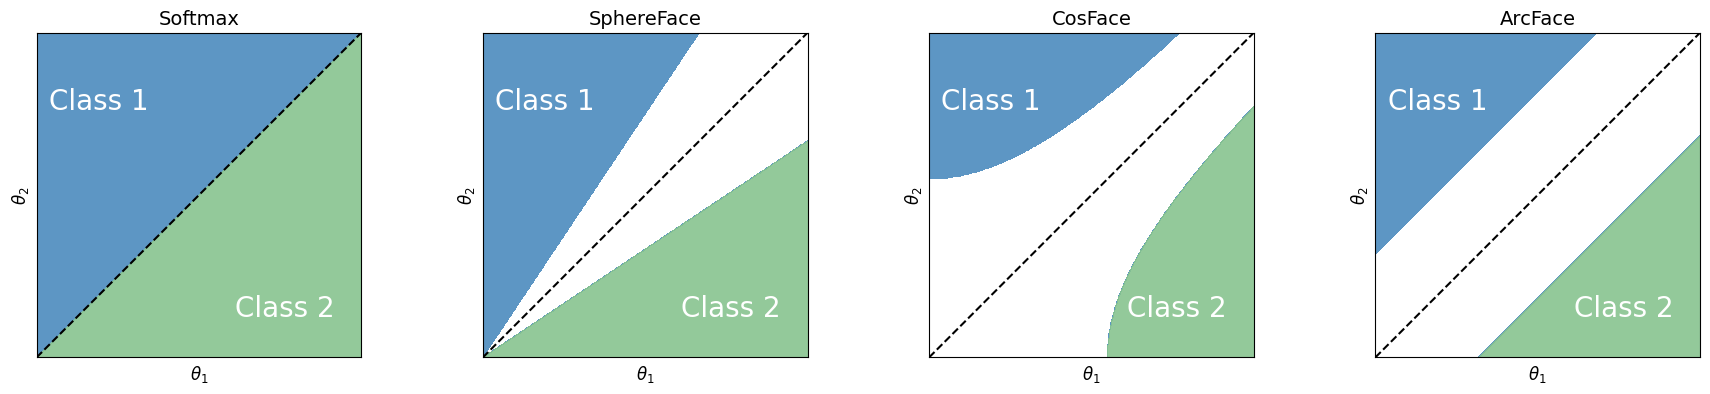

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Tạo lưới góc θ từ 0 đến π/2 (radians)
theta = np.linspace(0, np.pi / 2, 500)
T1, T2 = np.meshgrid(theta, theta)

# Các hàm phân vùng áp dụng margin cho cả hai class
def softmax_decision(t1, t2):
    return np.where(np.cos(t1) > np.cos(t2), 1,
           np.where(np.cos(t1) < np.cos(t2), 2, 0))

def sphereface_decision(t1, t2, m=1.5):
    gt1 = np.cos(m * t1)  # class 1 là ground-truth
    gt2 = np.cos(m * t2)  # class 2 là ground-truth
    return np.where(gt1 > np.cos(t2), 1,
           np.where(np.cos(t1) < gt2, 2, 0))

def cosface_decision(t1, t2, m=0.35):
    gt1 = np.cos(t1) - m
    gt2 = np.cos(t2) - m
    return np.where(gt1 > np.cos(t2), 1,
           np.where(np.cos(t1) < gt2, 2, 0))

def arcface_decision(t1, t2, m=0.5):
    gt1 = np.cos(t1 + m)
    gt2 = np.cos(t2 + m)
    return np.where(gt1 > np.cos(t2), 1,
           np.where(np.cos(t1) < gt2, 2, 0))

# Hàm vẽ từng biểu đồ
def plot_margin(ax, decision_func, title):
    Z = decision_func(T1, T2)
    ax.contourf(T1, T2, Z, levels=[0.5, 1.5, 2.5], colors=['#4B8BBE', '#87C38F'], alpha=0.9)
    ax.plot(theta, theta, '--', color='black')  # baseline θ1 = θ2
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(r'$\theta_1$', fontsize=12)
    ax.set_ylabel(r'$\theta_2$', fontsize=12)
    ax.set_xlim(0, np.pi/2)
    ax.set_ylim(0, np.pi/2)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

    ax.text(0.3, 1.2, "Class 1", color='white', fontsize=20, ha='center')
    ax.text(1.2, 0.2, "Class 2", color='white', fontsize=20, ha='center')


# Vẽ tất cả các biểu đồ
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

plot_margin(axs[0], softmax_decision, "Softmax")
plot_margin(axs[1], sphereface_decision, "SphereFace")
plot_margin(axs[2], cosface_decision, "CosFace")
plot_margin(axs[3], arcface_decision, "ArcFace")

plt.tight_layout()
plt.show()


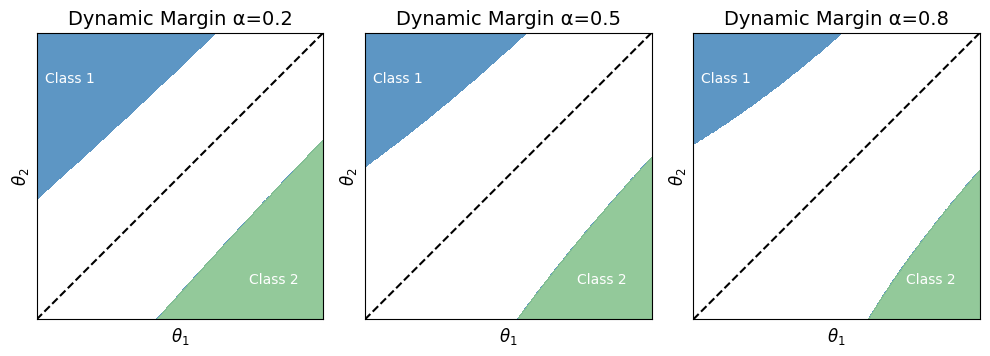

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Tạo lưới góc θ từ 0 đến π/2 (radians)
theta = np.linspace(0, np.pi / 2, 500)
T1, T2 = np.meshgrid(theta, theta)

# Hàm quyết định cho CombinedDynamicMarginLoss
def dynamic_margin_decision_with_labels(t1, t2, m1, m2, m3, alpha):
    cos_t1 = np.cos(t1)
    cos_t2 = np.cos(t2)

    # GT = class 1
    h1 = 1.0 - (cos_t1 - cos_t2)
    m_i1 = m2 + alpha * h1
    phi1 = np.cos(m1 * t1 + m_i1) - m3

    # GT = class 2
    h2 = 1.0 - (cos_t2 - cos_t1)
    m_i2 = m2 + alpha * h2
    phi2 = np.cos(m1 * t2 + m_i2) - m3

    decision = np.where(phi1 > cos_t2, 1,
                np.where(phi2 > cos_t1, 2, 0))
    return decision

# Hàm vẽ biểu đồ phân vùng có chú thích
def plot_dynamic_margin(ax, alpha, title):
    Z = dynamic_margin_decision_with_labels(T1, T2, m1=1.0, m2=0.5, m3=0, alpha=alpha)
    ax.contourf(T1, T2, Z, levels=[0.5, 1.5, 2.5], colors=['#4B8BBE', '#87C38F'], alpha=0.9)
    ax.plot(theta, theta, '--', color='black')  # baseline θ1 = θ2
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(r'$\theta_1$', fontsize=12)
    ax.set_ylabel(r'$\theta_2$', fontsize=12)
    ax.set_xlim(0, np.pi/2)
    ax.set_ylim(0, np.pi/2)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

    # Chú thích vùng
    ax.text(0.18, 1.3, "Class 1", color='white', fontsize=10, ha='center')
    ax.text(1.3, 0.2, "Class 2", color='white', fontsize=10, ha='center')
# Vẽ biểu đồ cho các giá trị alpha khác nhau
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
plot_dynamic_margin(axs[0], alpha=0.2, title="Dynamic Margin α=0.2")
plot_dynamic_margin(axs[1], alpha=0.5, title="Dynamic Margin α=0.5")
plot_dynamic_margin(axs[2], alpha=0.8, title="Dynamic Margin α=0.8")
plt.tight_layout()
plt.show()

In [ ]:
!unzip /content/Test_loss_dataset.zip

Archive:  /content/Test_loss_dataset.zip
   creating: Test_loss_dataset/
   creating: Test_loss_dataset/1027/
  inflating: Test_loss_dataset/1027/0.png  
  inflating: Test_loss_dataset/1027/1.png  
  inflating: Test_loss_dataset/1027/10.png  
  inflating: Test_loss_dataset/1027/11.png  
  inflating: Test_loss_dataset/1027/12.png  
  inflating: Test_loss_dataset/1027/13.png  
  inflating: Test_loss_dataset/1027/14.png  
  inflating: Test_loss_dataset/1027/15.png  
  inflating: Test_loss_dataset/1027/16.png  
  inflating: Test_loss_dataset/1027/17.png  
  inflating: Test_loss_dataset/1027/18.png  
  inflating: Test_loss_dataset/1027/19.png  
  inflating: Test_loss_dataset/1027/2.png  
  inflating: Test_loss_dataset/1027/20.png  
  inflating: Test_loss_dataset/1027/21.png  
  inflating: Test_loss_dataset/1027/22.png  
  inflating: Test_loss_dataset/1027/23.png  
  inflating: Test_loss_dataset/1027/24.png  
  inflating: Test_loss_dataset/1027/25.png  
  inflating: Test_loss_dataset/1027/26


🔧 Training NormSoftmax...


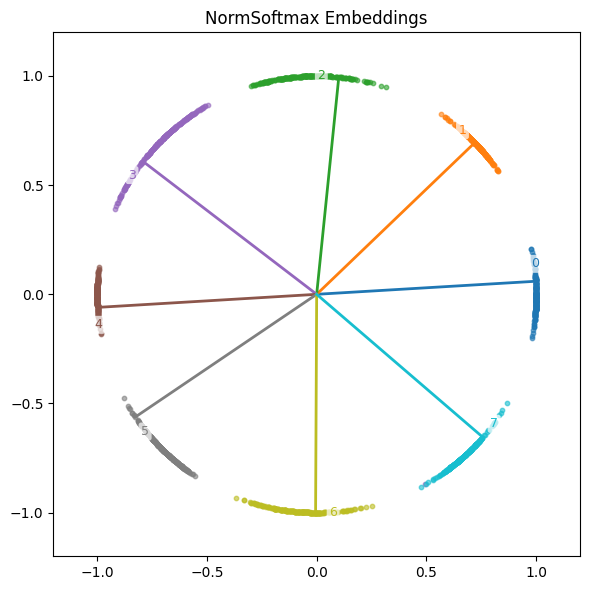


🔧 Training CosFace...


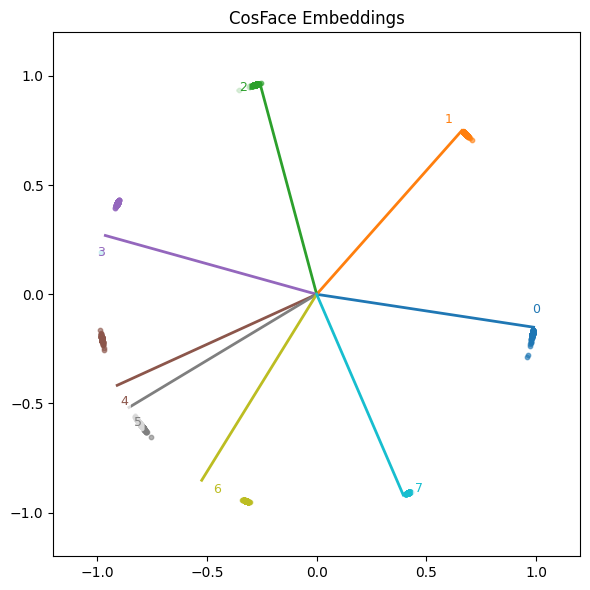


🔧 Training ArcFace...


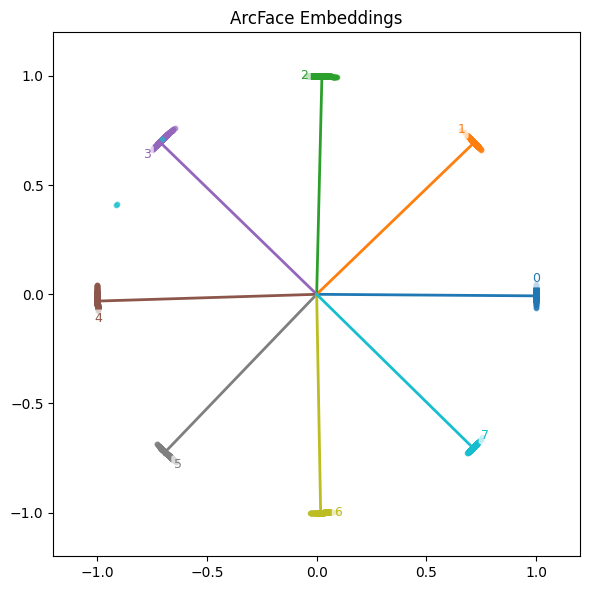


🔧 Training CombinedDynamicMargin...


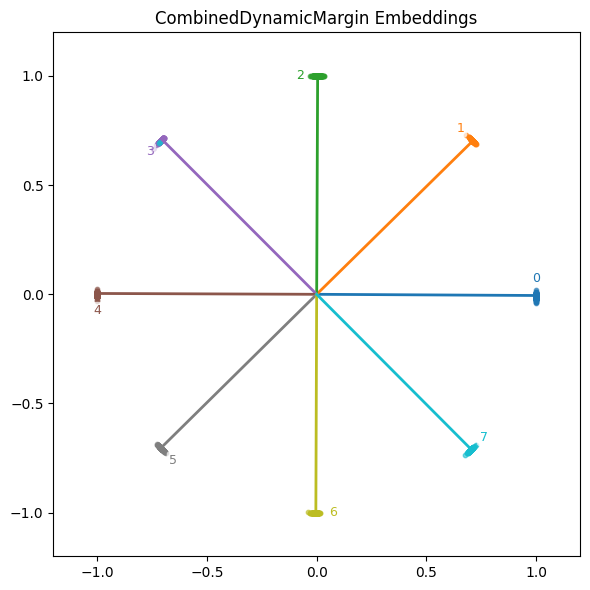

In [ ]:
# Import các thư viện cần thiết
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import numpy as np
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import math

# ===================== 1. Backbone Model =====================
class IResNetBackbone(nn.Module):
    def __init__(self, embedding_dim=2):
        super(IResNetBackbone, self).__init__()
        base_model = models.resnet18(pretrained=False)
        base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # bỏ FC cuối
        self.embedding = nn.Linear(512, embedding_dim, bias=False)       # đầu ra cuối cùng vẫn là 512 chiều
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        x = F.normalize(x, dim=1)
        return x


def init_weights_on_unit_circle(weight: torch.nn.Parameter):
    """
    Khởi tạo trọng số đều trên hình tròn đơn vị 2D.
    """
    num_classes = weight.size(0)
    theta = torch.linspace(0, 2 * math.pi, num_classes + 1)[:-1]
    x = torch.cos(theta)
    y = torch.sin(theta)
    weight_data = torch.stack([x, y], dim=1)
    with torch.no_grad():
        weight.copy_(weight_data)

# ===================== 2. Norm-Softmax Head =====================
class NormSoftmaxHead(nn.Module):
    def __init__(self, embedding_dim, num_classes, s=32.0):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(num_classes, embedding_dim))
        # nn.init.xavier_uniform_(self.weight)
        init_weights_on_unit_circle(self.weight)
        self.s = s

    def forward(self, x, labels=None):
        cosine = F.linear(F.normalize(x), F.normalize(self.weight))
        return self.s * cosine

# ===================== 3. CosFace Head =====================
class CosFaceHead(nn.Module):
    def __init__(self, embedding_dim, num_classes, s=32.0, m=0.45):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(num_classes, embedding_dim))
        # nn.init.xavier_uniform_(self.weight)
        init_weights_on_unit_circle(self.weight)
        self.s = s
        self.m = m

    def forward(self, x, labels):
        cosine = F.linear(F.normalize(x), F.normalize(self.weight))
        logits = cosine.clone()
        logits[torch.arange(x.size(0)), labels] -= self.m
        return self.s * logits

# ===================== 4. ArcFace Head =====================
class ArcFaceHead(nn.Module):
    def __init__(self, embedding_dim, num_classes, s=32.0, m=0.5):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(num_classes, embedding_dim))
        # nn.init.xavier_uniform_(self.weight)
        init_weights_on_unit_circle(self.weight)
        self.s = s
        self.m = m

    def forward(self, x, labels):
        cosine = F.linear(F.normalize(x), F.normalize(self.weight))
        theta = torch.acos(torch.clamp(cosine, -1.0 + 1e-7, 1.0 - 1e-7))
        phi = torch.cos(theta + self.m)
        logits = cosine.clone()
        logits[torch.arange(x.size(0)), labels] = phi[torch.arange(x.size(0)), labels]
        return self.s * logits

# ===================== 5. Combined Dynamic Margin Loss =====================
class CombinedDynamicMarginLoss(nn.Module):
    def __init__(self, embedding_dim, num_classes, s=32.0, m0=0.5, alpha=0.15):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(num_classes, embedding_dim))
        # nn.init.xavier_uniform_(self.weight)
        init_weights_on_unit_circle(self.weight)
        self.s = s
        self.m0 = m0
        self.alpha = alpha

    def forward(self, x, labels):
        W = F.normalize(self.weight)
        x = F.normalize(x)
        cosine = F.linear(x, W)
        gt_cos = cosine[torch.arange(x.size(0)), labels]
        max_neg_cos = cosine.clone()
        max_neg_cos[torch.arange(x.size(0)), labels] = -1.0
        hardest_neg = max_neg_cos.max(dim=1).values

        delta = gt_cos - hardest_neg
        hi = 1 - delta.clamp(min=0.0, max=1.0)
        margin = self.m0 + self.alpha * hi

        theta = torch.acos(gt_cos.clamp(-1 + 1e-7, 1 - 1e-7))
        phi = torch.cos(theta + margin)

        logits = cosine.clone()
        logits[torch.arange(x.size(0)), labels] = phi
        logits *= self.s

        return F.cross_entropy(logits, labels)

# ===================== 6. Training & Visualization =====================
def train(model, head, dataloader, loss_fn, optimizer, device, num_epochs):
    model.train()
    head.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            features = model(imgs)
            if isinstance(loss_fn, type(None)):
                loss = head(features, labels)
            else:
                logits = head(features, labels)
                loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / (pbar.n + 1e-6))

@torch.no_grad()
def visualize(model, dataloader, device, title="Embedding Space", head=None):
    model.eval()
    all_feats, all_labels = [], []

    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        feats = model(imgs).cpu()
        all_feats.append(feats)
        all_labels.append(labels)

    all_feats = torch.cat(all_feats).numpy()
    all_labels = torch.cat(all_labels).numpy()

    plt.figure(figsize=(6, 6))

    # Xác định danh sách màu consistent
    num_classes = len(np.unique(all_labels))
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))  # hoặc tab20 nếu nhiều lớp hơn

    # Vẽ các điểm đặc trưng và lưu màu theo lớp
    for cls in range(num_classes):
        idx = all_labels == cls
        plt.scatter(all_feats[idx, 0], all_feats[idx, 1], label=f"Class {cls}", s=10, alpha=0.6, color=colors[cls])

    # Vẽ vector trung tâm và chú thích lệch nhẹ khỏi đỉnh
    if hasattr(head, 'weight'):
        centers = F.normalize(head.weight, dim=1).detach().cpu().numpy()
        for i, center in enumerate(centers):
            plt.plot([0, center[0]], [0, center[1]], color=colors[i], linewidth=2)

            # Tính góc để dịch text lệch theo hướng vuông góc
            angle = np.arctan2(center[1], center[0])
            offset = 0.08
            dx = -np.sin(angle) * offset
            dy = np.cos(angle) * offset

            plt.text(center[0] + dx, center[1] + dy, str(i),
                     fontsize=9, ha='center', va='center', color=colors[i],
                     bbox=dict(boxstyle="round,pad=0.2", edgecolor='none', facecolor='white', alpha=0.7))

    plt.title(title)
    # plt.legend(loc='upper right', fontsize=8)
    # plt.gca().set_aspect('equal')
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


def create_balanced_mnist_split(num_classes=10, samples_per_class=100, test_samples_per_class=100):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])
    full_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    class_indices = {i: [] for i in range(num_classes)}
    for idx, (_, label) in enumerate(full_dataset):
        label = int(label)
        if label < num_classes:
            if len(class_indices[label]) < samples_per_class + test_samples_per_class:
                class_indices[label].append(idx)

    # Kiểm tra đủ dữ liệu
    for cls in range(num_classes):
        if len(class_indices[cls]) < samples_per_class + test_samples_per_class:
            raise ValueError(f"Không đủ mẫu cho lớp {cls}")

    train_indices = []
    test_indices = []
    for cls in range(num_classes):
        cls_indices = class_indices[cls]
        train_indices += cls_indices[:samples_per_class]
        test_indices += cls_indices[samples_per_class:samples_per_class + test_samples_per_class]

    train_set = Subset(full_dataset, train_indices)
    test_set = Subset(full_dataset, test_indices)

    train_loader = DataLoader(train_set, batch_size=8192, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=8192, shuffle=False)
    return train_loader, test_loader

import torchvision
def visualize_per_class_from_loader(data_loader, num_classes=10, samples_per_class=10):
    import matplotlib.pyplot as plt

    class_to_images = {i: [] for i in range(num_classes)}

    for images, labels in data_loader:
        for img, label in zip(images, labels):
            label = int(label)
            if len(class_to_images[label]) < samples_per_class:
                class_to_images[label].append(img)
        # Dừng nếu đã đủ ảnh cho tất cả lớp
        if all(len(v) >= samples_per_class for v in class_to_images.values()):
            break

    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 1.2, num_classes * 1.2))

    for cls in range(num_classes):
        for i in range(samples_per_class):
            ax = axes[cls, i]
            ax.imshow(class_to_images[cls][i].squeeze(), cmap='gray')
            ax.set_title(f"Label: {cls}", fontsize=8)
            ax.axis('off')

    plt.tight_layout()
    plt.show()



# ===================== 8. Main Execution =====================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 8
    samples_per_class =250
    test_samples_per_class = 50
    num_epochs = 150
    train_dataloader, test_dataloader = create_balanced_mnist_split(num_classes, samples_per_class, test_samples_per_class)
    # visualize_per_class_from_loader(train_dataloader,  num_classes=num_classes, samples_per_class=20)

    losses = [
        ("NormSoftmax", NormSoftmaxHead(2 , num_classes).to(device), F.cross_entropy),
        ("CosFace", CosFaceHead(2, num_classes).to(device), F.cross_entropy),
        ("ArcFace", ArcFaceHead(2, num_classes).to(device), F.cross_entropy),
        ("CombinedDynamicMargin", CombinedDynamicMarginLoss(2, num_classes).to(device), None),
    ]

    for name, head, loss_fn in losses:
        print(f"\n🔧 Training {name}...")
        model = IResNetBackbone().to(device)
        optimizer = torch.optim.Adam(list(model.parameters()) + list(head.parameters()), lr=0.01)
        train(model, head, train_dataloader, loss_fn, optimizer, device, num_epochs=num_epochs)
        visualize(model, train_dataloader, device, title=f"{name} Embeddings", head=head)

